In [1]:
import os
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%run model.py
%run plotPerformance.py
%run paramPipeline.py
%run betweenCompare.py

%matplotlib inline

np.random.seed(1234)

# Functions 

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

data = pd.read_csv(datadir + "complete.csv", index_col = 0)

# Feature Selection

In [3]:
#Drop reputation-based features
data2 = data.drop(["followers_count", "friends_count"], axis = 1)

In [4]:
#Drop highly correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

#Ignore mv features
mv_cols = list(data.filter(like='mv').columns)
mv_cols
data_mv = data[data.columns.difference(mv_cols)]

data3 = correlation(data_mv, 0.75)

In [5]:
#three models to test the datasets
dt = DecisionTreeClassifier(criterion="entropy")
lr = LogisticRegression()

data_choosers = {'data': data, 'data2': data2, 'data3': data3}

kfolds = KFold(10, True)

In [6]:
#Choose data set with highest mean auc
for dataset in data_choosers:
    aucs = list(cross_val_score(dt, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    aucs.extend(cross_val_score(lr, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    
    print("For {0}, mean auc is {1}:".format(dataset, np.round(np.mean(aucs), decimals = 3))) 

For data, mean auc is 0.717:
For data2, mean auc is 0.717:
For data3, mean auc is 0.713:


In [7]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data2.drop('label', 1), data2.label, test_size=0.2)

In [8]:
dt = Model("Decision Tree", DecisionTreeClassifier(criterion="entropy"), X_train, y_train, X_test, y_test)

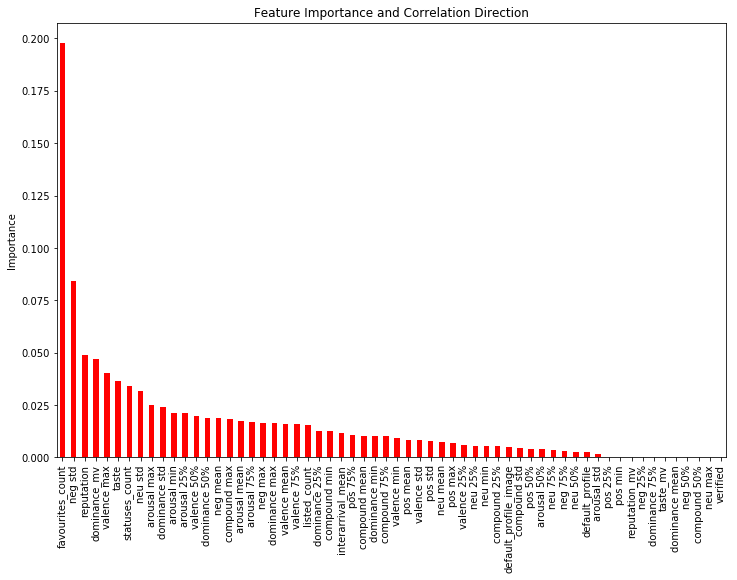

In [9]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.best_iteration.model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [10]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

#Scale scalable features
scalable = X_train_filt[X_train_filt.columns.difference(mv_cols)].select_dtypes(exclude = ["bool"]).columns
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_filt[scalable].copy())

X_trained = X_train_filt.copy()
X_tested = X_test_filt.copy()


X_trained[scalable] = scaler.transform(X_trained[scalable])
X_tested[scalable] = scaler.transform(X_tested[scalable])

In [11]:
# Baseline Logistic Regression and SVM
lr = Model("Logistic Regression", LogisticRegression(C=1e30), X_trained, y_train, X_tested, y_test)
knn = Model("KNN", KNeighborsClassifier(35), X_trained, y_train, X_tested, y_test)

kfold = KFold(10, True)
lr_cv = cross_val_score(lr.best_iteration.model, X_trained, y_train, cv = kfold, scoring="roc_auc")
knn_cv = cross_val_score(knn.best_iteration.model, X_trained, y_train, cv = kfold, scoring="roc_auc")

In [12]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

print("\nKNN Mean CV AUC Score: {:0.3}".format(np.mean(knn_cv))+
      "\nKNN StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(knn_cv)/len(knn_cv))))

LR Mean CV AUC Score: 0.799
LR StdErr CV AUC Score: 0.0129

KNN Mean CV AUC Score: 0.79
KNN StdErr CV AUC Score: 0.00726


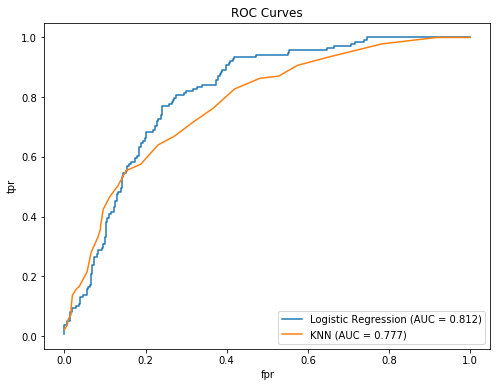

In [13]:
# ROC Curve for single test split baseline models

betweenCompare([lr,knn])

# Pipelines

# GBM 

## Model Initialization

In [14]:
gbc = Model("GBC", GradientBoostingClassifier(), X_trained, y_train, X_tested, y_test)

 ## Iteration 1

Best Score: 0.85406

Best Params:  {'estimator__n_estimators': 70}


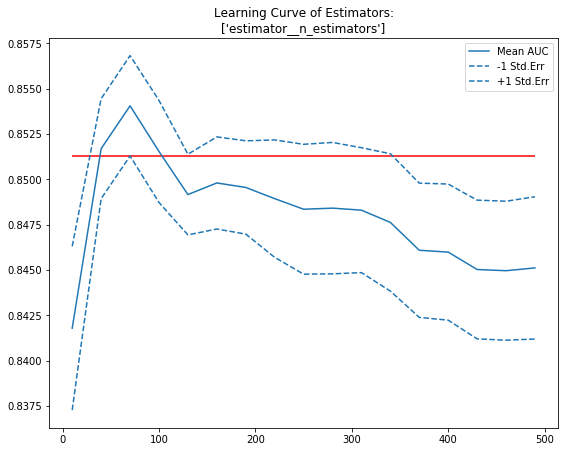

In [15]:
gbc.addIteration("Estimators", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,500,30))}, plot = True)


## Iteration 2 

Best Score: 0.855912

Best Params:  {'estimator__max_depth': 2}


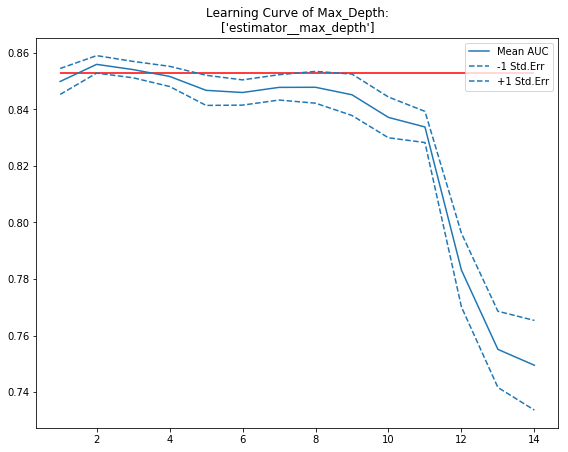

In [16]:
gbc.addIteration("Max_Depth", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_depth': list(range(1,15))}, plot = True)

## Iteration 3

Best Score: 0.860448

Best Params:  {'estimator__min_samples_leaf': 155}


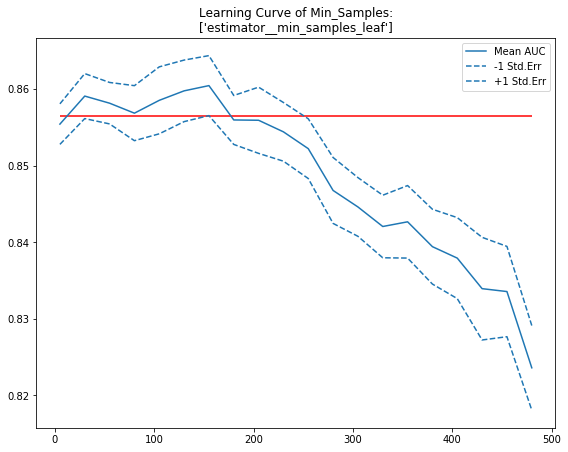

In [17]:
gbc.addIteration("Min_Samples", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__min_samples_leaf': list(range(5,500,25))}, plot = True)


## Iteration 4

Best Score: 0.860422

Best Params:  {'estimator__max_features': 16}


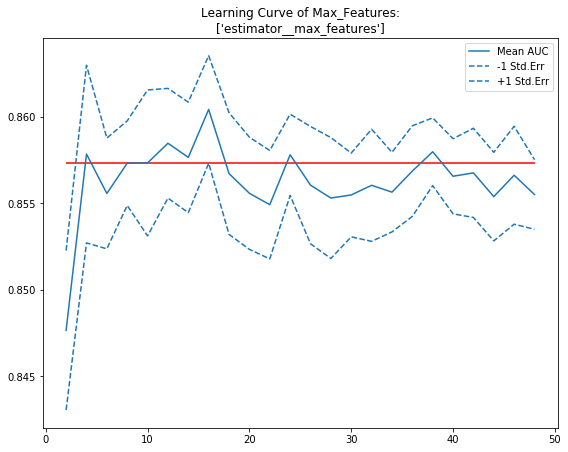

In [18]:
gbc.addIteration("Max_Features", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_features': list(range(2,X_trained.shape[1],2))}, plot = True)


## Iteration 5

Best Score: 0.863161

Best Params:  {'estimator__subsample': 0.69999999999999996}


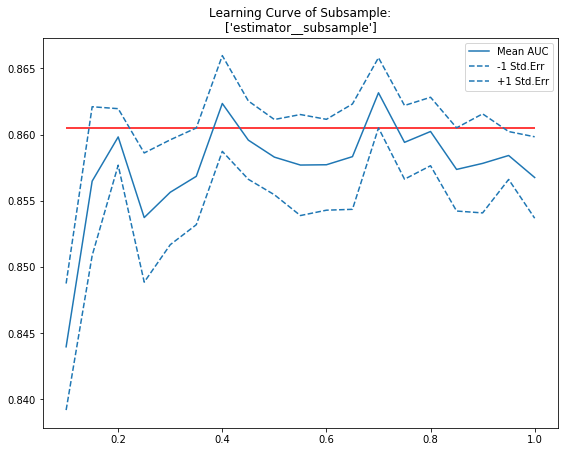

In [19]:
gbc.addIteration("Subsample", 
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100}, plot = True)


## Interation 6 

Best Score: 0.859345

Best Params:  {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 210}


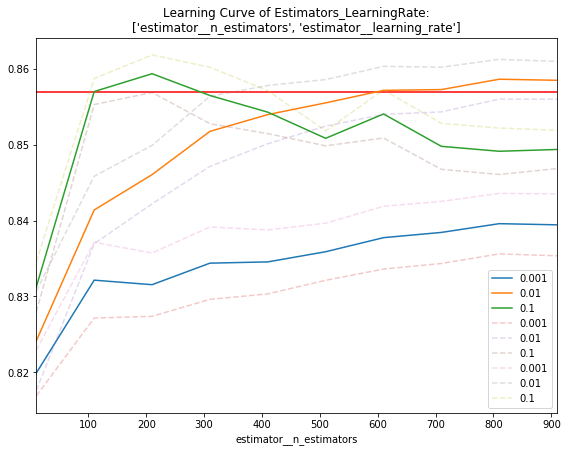

In [20]:
gbc.addIteration("Estimators_LearningRate",
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,1000,100)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]}, plot = True)


# Dimension Reduction

## Model Initialization

In [21]:
gb1 = GradientBoostingClassifier()
pca1 = PCA(whiten = True)

pipe = Pipeline(steps=[('pca', pca1), ('boosted', gb1)])
pca1.fit(X_trained)

X_train_pca = pd.DataFrame(pca1.transform(X_trained))
X_test_pca = pd.DataFrame(pca1.transform(X_tested))

gbc_pca = Model("Dimension Reduction", pipe, X_train_pca, y_train, X_test_pca, y_test)

## Iteration 1

Best Score: 0.804504

Best Params:  {'estimator__pca__n_components': 47}


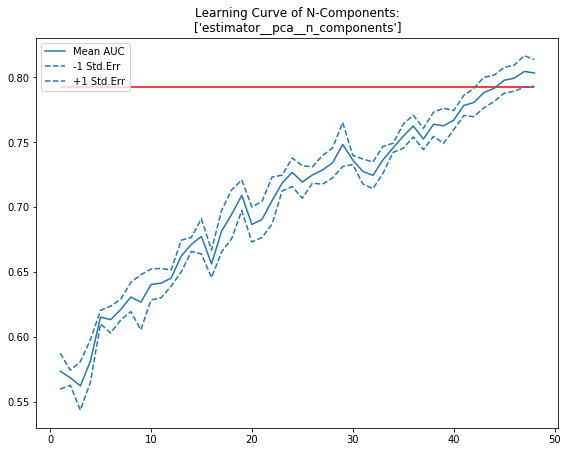

In [22]:
gbc_pca.addIteration("N-Components", pipe, 
                     dict(estimator__pca__n_components = list(range(1,X_train_pca.shape[1]))), 
                     plot = True)


## Iteration 2

Best Score: 0.805273

Best Params:  {'estimator__boosted__n_estimators': 110}


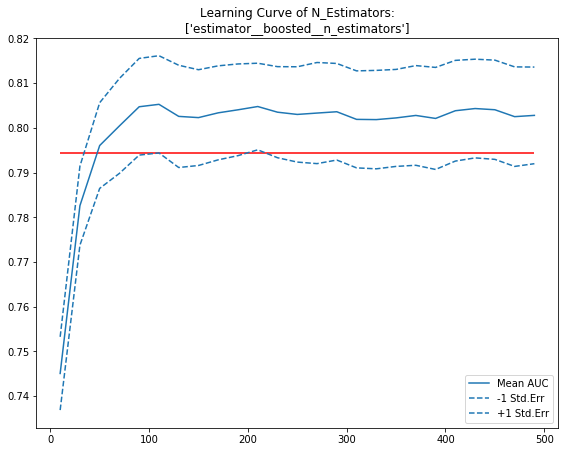

In [23]:
gb2 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])
pca2 = PCA(whiten = True)
pca2.fit(X_trained)

gbc_pca.X_train = pd.DataFrame(pca2.transform(X_trained))
gbc_pca.X_test = pd.DataFrame(pca2.transform(X_tested))

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb2)])

gbc_pca.addIteration("N_Estimators", pipe, 
                     dict(estimator__boosted__n_estimators = list(range(10,500,20))), 
                     plot = True)

## Iteration 3

Best Score: 0.806008

Best Params:  {'estimator__boosted__max_depth': 4}


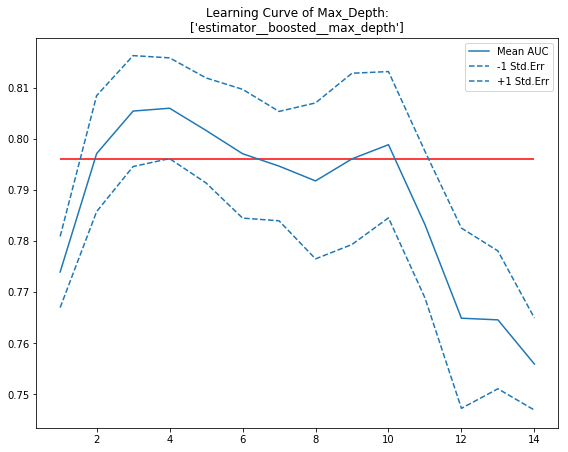

In [24]:
gb3 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb3)])

gbc_pca.addIteration("Max_Depth", pipe, 
                     dict(estimator__boosted__max_depth = list(range(1,15))), 
                     plot = True)

## Iteration 4

Best Score: 0.806343

Best Params:  {'estimator__boosted__min_samples_leaf': 115}


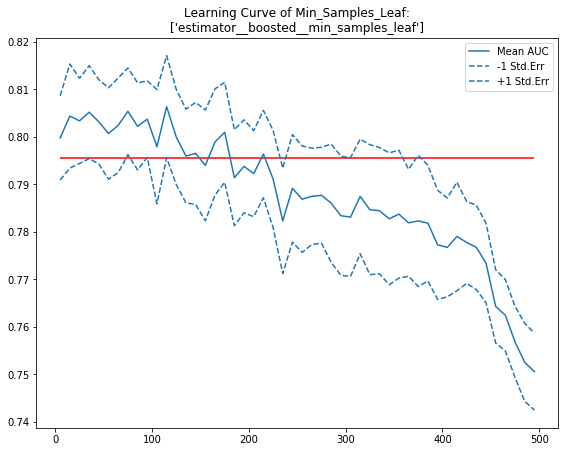

In [25]:
gb4 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb4)])

gbc_pca.addIteration("Min_Samples_Leaf", pipe, 
                     dict(estimator__boosted__min_samples_leaf = list(range(5,500,10))), 
                     plot = True)


## Iteration 5

Best Score: 0.810942

Best Params:  {'estimator__boosted__subsample': 0.55000000000000004}


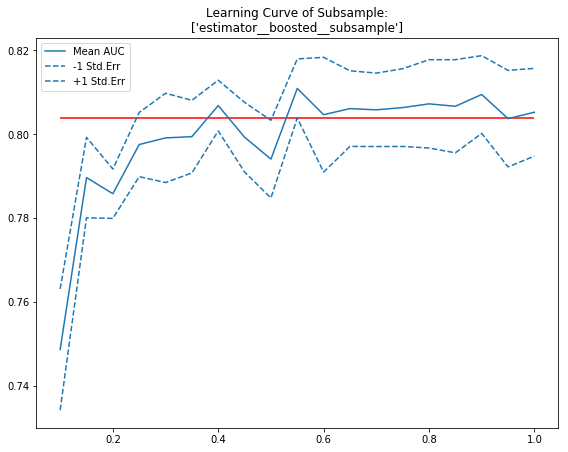

In [26]:
gb5 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb5)])

gbc_pca.addIteration("Subsample", pipe, 
                     dict(estimator__boosted__subsample = np.array(list(range(10,105,5)))/100), 
                     plot = True)

## Iteration 6

Best Score: 0.804034

Best Params:  {'estimator__boosted__learning_rate': 0.1}


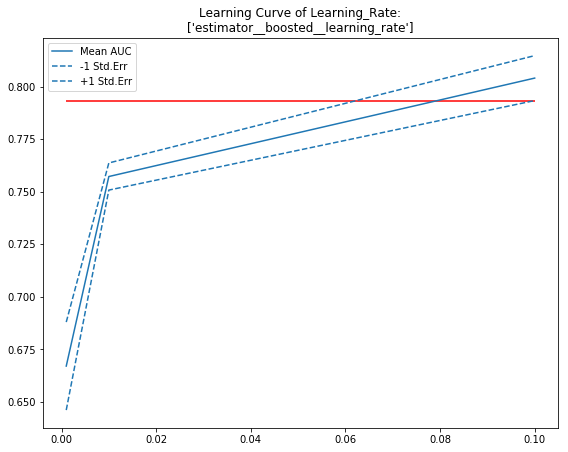

In [27]:
gb6 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb6)])

gbc_pca.addIteration("Learning_Rate", pipe, 
                     dict(estimator__boosted__learning_rate = [10**x for x in range(-3,0)]), 
                     plot = True)

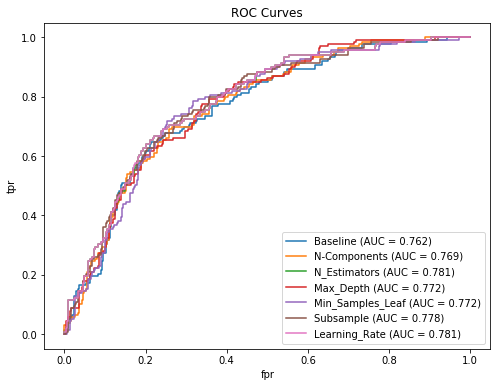

In [28]:
gbc_pca.withinCompare()

# Model Comparison


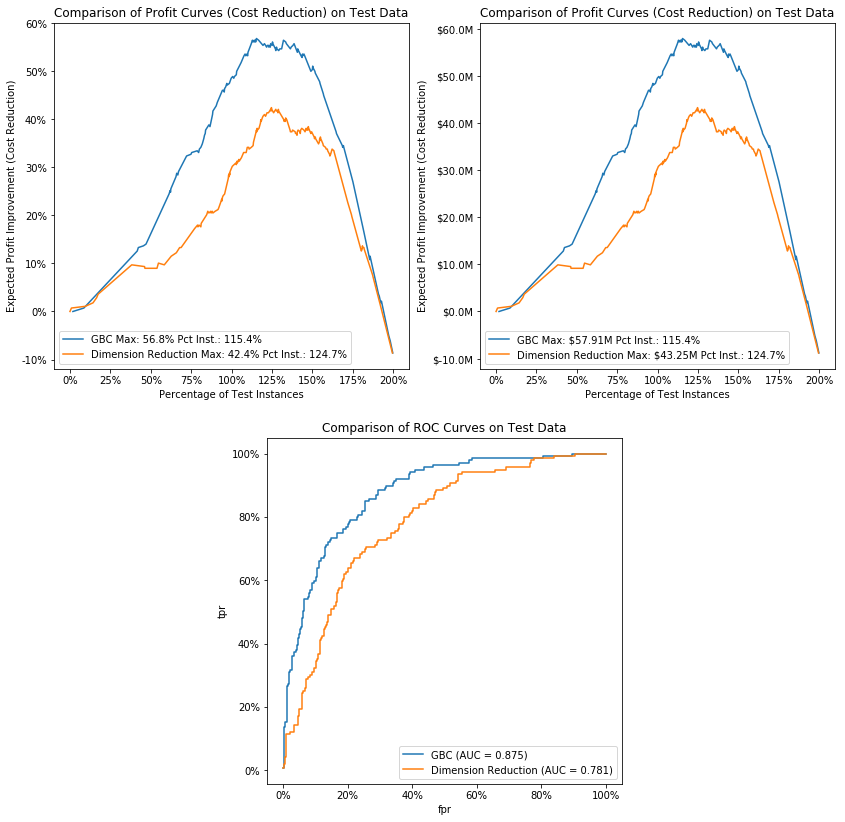

In [29]:
plotPerformance([gbc, gbc_pca])